# inspect TSS binding around DEGs from deSEQ2

todo: write overview/goal

- where did mm10 come from
- which datasets I am inspecting here

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import bbi

In [2]:
import gffutils
import pybedtools
from pybedtools.featurefuncs import TSS
from gffutils.helpers import asinterval
import bioframe as bf
from gtfparse import read_gtf

In [4]:
# data needed from sleuth to compare 

# s2c to collapse tpm into averages
s2c = pd.read_csv("/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/supplementary/s2c.csv", index_col = 0)

# t2g to compare gene-level analysis
t2g = pd.read_csv("/project/fudenber_735/genomes/mm10/ensembl/ensembl_relational_downloads/biomaRt_mm10_t2g.csv", index_col = 0)


In [5]:
conditions = s2c['condition'].unique()
conditions = [x.strip().replace("-","_").split("RNA_seq_")[1] for x in conditions]

conditions

['CTCF_AID_untreated',
 'CTCF_AID_auxin1day',
 'CTCF_AID_auxin2days',
 'CTCF_AID_auxin4days',
 'CTCF_AID_washoff2days',
 'WT_untagged_untreated',
 'WT_untagged_auxin2days',
 'WT_untagged_auxin4days']

### TODO:
- [ ] re-generate everything for ctcf dataset using mm10
    - check on tss results, look for repetitions/any cleaning steps we should do?
- [ ] import deseq results for dNipL
    - /project/fudenber_735/collaborations/karissa_2022/RNAseq-mapped/DE-results/pairwise_deseq_wt_dTAG_13_24h_vs_DMSO_24h.csv
- [ ] do same TSS/promoter binding analysis --> possibly try different windows? First see what we get at +/-1000 
- [ ] try to see if daler tutorial + tools are better than bbi stackup
    - generate for one of the datasets? https://github.com/daler/metaseq/blob/master/doc/source/example_session.ipynb .
- [ ] import enhancer data --> 6(d) https://www.cell.com/cell/pdf/S0092-8674(17)30531-7.pdf 
- [ ] slightly more complex (maybe a good opportunity for daler data: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7610352/figure/F10/?report=objectonly)

In [6]:
# import DEseq results

# Importing the .csv outputs from sleuth WT for each of the conditions into pandas dataframes:
deseq_results = {}

folder = "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/deseq-mm10-results/"

for c in conditions[1:]:
    
    df = pd.read_csv(folder+"pairwise_deseq_wt_"+c+".csv", index_col = 0)
    deseq_results[c] = df


In [48]:
# Now, can access the DE results for a dataset by it's name as dict key:
deseq_results['CTCF_AID_auxin1day'].head(5)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMUSG00000000001,4946.921561,-0.030823,0.252413,-0.122113,0.902809,0.999976
ENSMUSG00000000003,0.000000,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000000028,2277.235216,-0.091748,0.176626,-0.519447,0.603449,0.999976
ENSMUSG00000000031,27.699104,-0.329884,0.641314,-0.514388,0.606981,0.999976
ENSMUSG00000000037,330.518198,2.020011,0.509448,3.965098,0.000073,0.007284


## Inspecting tss data for mm10

tsses.csv for mm10 generated by gff utils from the .gtf file for mm10: `Mus_musculus.GRCm38.102.gtf.gz`
See **compare-sleuth-results.ipynb** section **Trying gff utils to read GTF file --> get TSS**.

Want to get a better understanding of number of unique ids, where the id's came from (this .gtf file had transcript and gene annotations, so gff utils' prediction of transcripts based on exons may not have been necessary). Note: I ran gff_utils with the default settings (default behavior is to predict transcripts) to mimic what was done with the mm9 dataset, but also ran it with the settings `disable_infer_genes=True, disable_infer_transcripts=True` to speed up the process. The output db's generated from this are called `genomes/mm10/ensembl/tsses.gtf` and `genomes/mm10/ensembl/tsses_from_annotated.Mus_musculus.GRCm38.102.gtf`, respectively.

Essentially, following the method outlined in this example session by daler for metaseq. Side note: maybe want to try out metaseq before attempting snakemake/full workflow. Seems like it makes it easier to make intermediate objects, which will reduce repetive work (or maybe I should save some intermediate object/numpy version following the bbi stackup). 

**note:** Using the genome.db generated from the gtf could be useful later for looking into more detail about genes/mapping/etc. Using it to extract TSS's is one niche, but it has many useful ways of extracting/inspecting different features. http://daler.github.io/gffutils/ 

In [16]:
# Reading gtf file that contains only the parsed TSSes, generated from default gff_utils
tss_df = read_gtf('/project/fudenber_735/genomes/mm10/ensembl/tsses.gtf')

# cleaning out less-well defined chromosome numbers
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('NT_'))]
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('MT'))]

# paste 'chr' to all chromosome names
tss_df["seqname"] = 'chr' + tss_df["seqname"]

# rename column to chrom to match bedframe/bioframe format
tss_df = tss_df.rename(columns= {"seqname" : "chrom"})

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'transcript_id', 'transcript_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'ccds_id']
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been de

In [ ]:
# Reading gtf file that contains only the parsed TSSes, generated without disable_infer_genes=True and disable_infer_transcripts=True.
## this was done to speed up generation
no_infer_tss_df = read_gtf('/project/fudenber_735/genomes/mm10/ensembl/tsses_from_annotated.Mus_musculus.GRCm38.102.gtf')

# cleaning out less-well defined chromosome numbers
no_infer_tss_df = no_infer_tss_df.loc[False==( no_infer_tss_df['seqname'].str.contains('NT_'))]
no_infer_tss_df = no_infer_tss_df.loc[False==( no_infer_tss_df['seqname'].str.contains('MT'))]

# paste 'chr' to all chromosome names
no_infer_tss_df["seqname"] = 'chr' + no_infer_tss_df["seqname"]

# rename column to chrom to match bedframe/bioframe format
no_infer_tss_df = no_infer_tss_df.rename(columns= {"seqname" : "chrom"})

In [18]:
print("Length of default tss predictions: ",str(len(tss_df)))
print("Length of tss predictions without gene/transcript inference: ", str(len(no_infer_tss_df)))
tss_df.head(10)

Length of default tss predictions:  142662
Length of tss predictions without gene/transcript inference:  142662


,chrom,source,feature,start,end,score,strand,frame,gene_id,gene_version,...,havana_gene,havana_gene_version,transcript_name,transcript_source,transcript_biotype,havana_transcript,havana_transcript_version,tag,transcript_support_level,ccds_id
0,chr1,havana,transcript,3073252,3073252,NaN,+,0,ENSMUSG00000102693,1,...,OTTMUSG00000049935,1,4933401J01Rik-201,havana,TEC,OTTMUST00000127109,1,basic,NA,
1,chr1,ensembl,transcript,3102015,3102015,NaN,+,0,ENSMUSG00000064842,1,...,,,Gm26206-201,ensembl,snRNA,,,basic,NA,
2,chr1,havana,transcript,3216345,3216345,NaN,-,0,ENSMUSG00000051951,5,...,OTTMUSG00000026353,2,Xkr4-203,havana,processed_transcript,OTTMUST00000086625,1,,1,
3,chr1,havana,transcript,3215633,3215633,NaN,-,0,ENSMUSG00000051951,5,...,OTTMUSG00000026353,2,Xkr4-202,havana,processed_transcript,OTTMUST00000086624,1,,1,
4,chr1,ensembl_havana,transcript,3671499,3671499,NaN,-,0,ENSMUSG00000051951,5,...,OTTMUSG00000026353,2,Xkr4-201,ensembl_havana,protein_coding,OTTMUST00000065166,1,"CCDS,basic",1,CCDS14803
5,chr1,havana,transcript,3252756,3252756,NaN,+,0,ENSMUSG00000102851,1,...,OTTMUSG00000049958,1,Gm18956-201,havana,processed_pseudogene,OTTMUST00000127143,1,basic,NA,
6,chr1,havana,transcript,3368550,3368550,NaN,-,0,ENSMUSG00000103377,1,...,OTTMUSG00000049960,1,Gm37180-201,havana,TEC,OTTMUST00000127145,1,basic,NA,
7,chr1,havana,transcript,3377789,3377789,NaN,-,0,ENSMUSG00000104017,1,...,OTTMUSG00000049961,1,Gm37363-201,havana,TEC,OTTMUST00000127146,1,basic,NA,
8,chr1,havana,transcript,3467286,3467286,NaN,-,0,ENSMUSG00000103025,1,...,OTTMUSG00000049930,1,Gm37686-201,havana,TEC,OTTMUST00000127101,1,basic,NA,
9,chr1,havana,transcript,3466586,3466586,NaN,+,0,ENSMUSG00000089699,1,...,OTTMUSG00000026352,1,Gm1992-201,havana,antisense,OTTMUST00000065165,1,basic,3,


In [ ]:
print(tss_df.equals(no_infer_tss_df))

True


The two settings created equal df's --> good to know, with disable_infer vastly sped up the table generation. We'll use this in general when possible.

In [35]:
print(tss_df.columns)

Index(['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand',
       'frame', 'gene_id', 'gene_version', 'transcript_id',
       'transcript_version', 'gene_name', 'gene_source', 'gene_biotype',
       'havana_gene', 'havana_gene_version', 'transcript_name',
       'transcript_source', 'transcript_biotype', 'havana_transcript',
       'havana_transcript_version', 'tag', 'transcript_support_level',
       'ccds_id'],
      dtype='object')


### What kind of chromosomes do we have in here? Looking for anything weird/likely to mess up mapping

- already removed chromosomes that start with NT_xx or MT_xx
- not sure whether to remove/keep chrX, chrY. They were left in mm9 dataset, so will do that as well.

In [46]:
tss_df.groupby(['chrom']).count()

,source,feature,start,end,score,strand,frame,gene_id,gene_version,transcript_id,...,havana_gene,havana_gene_version,transcript_name,transcript_source,transcript_biotype,havana_transcript,havana_transcript_version,tag,transcript_support_level,ccds_id
chrom,,,,,,,,,,,,,,,,,,,,,
chr1,8591,8591,8591,8591,0,8591,8591,8591,8591,8591,...,8591,8591,8591,8591,8591,8591,8591,8591,8591,8591
chr10,6608,6608,6608,6608,0,6608,6608,6608,6608,6608,...,6608,6608,6608,6608,6608,6608,6608,6608,6608,6608
chr11,8732,8732,8732,8732,0,8732,8732,8732,8732,8732,...,8732,8732,8732,8732,8732,8732,8732,8732,8732,8732
chr12,5379,5379,5379,5379,0,5379,5379,5379,5379,5379,...,5379,5379,5379,5379,5379,5379,5379,5379,5379,5379
chr13,5652,5652,5652,5652,0,5652,5652,5652,5652,5652,...,5652,5652,5652,5652,5652,5652,5652,5652,5652,5652
chr14,5882,5882,5882,5882,0,5882,5882,5882,5882,5882,...,5882,5882,5882,5882,5882,5882,5882,5882,5882,5882
chr15,5161,5161,5161,5161,0,5161,5161,5161,5161,5161,...,5161,5161,5161,5161,5161,5161,5161,5161,5161,5161
chr16,4512,4512,4512,4512,0,4512,4512,4512,4512,4512,...,4512,4512,4512,4512,4512,4512,4512,4512,4512,4512
chr17,7097,7097,7097,7097,0,7097,7097,7097,7097,7097,...,7097,7097,7097,7097,7097,7097,7097,7097,7097,7097


In [50]:
# Removing pseudo chromosomes
before = len(tss_df)
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrGL'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrJH'))]
after = len(tss_df)

print("Removed " + str(before-after) + " rows.")

Removed 0 rows.


"Removed 95 rows" when run fresh.

### Looking at biotypes -- what should be cleaned?

description of biotypes: https://m.ensembl.org/info/genome/genebuild/biotypes.html

3 most common categories: 

In [51]:
tss_df['transcript_biotype'].nunique()

47

In [52]:
tss_df.groupby(['transcript_biotype'])['source'].describe().reset_index().sort_values(by='count', ascending=False)

,transcript_biotype,count,unique,top,freq
28,protein_coding,59281,3,havana,33164
31,retained_intron,21919,2,havana,21841
27,processed_transcript,15938,3,havana,15764
26,processed_pseudogene,10005,3,havana,9677
19,lincRNA,8922,3,havana,8606
24,nonsense_mediated_decay,7204,2,havana,7185
17,antisense,4634,3,havana,4397
10,TEC,3324,3,havana,3220
46,unprocessed_pseudogene,2732,2,havana,2694
21,miRNA,2202,2,mirbase,1187


In [66]:
tss_df.groupby(['transcript_biotype', 'transcript_source']).describe()

start                \
                                                      count          mean   
transcript_biotype                transcript_source                         
3prime_overlapping_ncRNA          ensembl               1.0  2.070228e+07   
                                  ensembl_havana        1.0  9.108849e+07   
                                  havana                2.0  6.928542e+07   
IG_C_gene                         ensembl_havana        8.0  1.079964e+08   
                                  havana               13.0  8.435380e+07   
...                                                     ...           ...   
translated_processed_pseudogene   havana               12.0  7.929805e+07   
translated_unprocessed_pseudogene havana                2.0  1.187844e+08   
unitary_pseudogene                havana               61.0  7.840434e+07   
unprocessed_pseudogene            ensembl_havana       38.0  5.403454e+07   
                                  havana             2694.0  5.784665e+07   

                                                                   \
                                                              std   
transcript_biotype                transcript_source                 
3prime_overlapping_ncRNA          ensembl                     NaN   
                                  ensembl_havana              NaN   
                                  havana             6.870694e+07   
IG_C_gene                         ensembl_havana     1.505944e+07   
                                  havana             4.525777e+07   
...                                                           ...   
translated_processed_pseudogene   havana             5.050476e+07   
translated_unprocessed_pseudogene havana             1.327668e+07   
unitary_pseudogene                havana             4.756919e+07   
unprocessed_pseudogene            ensembl_havana     4.740755e+07   
                                  havana             4.089794e+07   

                                                                  \
                                                             min   
transcript_biotype                transcript_source                
3prime_overlapping_ncRNA          ensembl             20702276.0   
                                  ensembl_havana      91088492.0   
                                  havana              20702276.0   
IG_C_gene                         ensembl_havana      70726434.0   
                                  havana              19062072.0   
...                                                          ...   
translated_processed_pseudogene   havana               6837655.0   
translated_unprocessed_pseudogene havana             109396329.0   
unitary_pseudogene                havana               3774779.0   
unprocessed_pseudogene            ensembl_havana       3512377.0   
                                  havana                695778.0   

                                                                   \
                                                              25%   
transcript_biotype                transcript_source                 
3prime_overlapping_ncRNA          ensembl            2.070228e+07   
                                  ensembl_havana     9.108849e+07   
                                  havana             4.499385e+07   
IG_C_gene                         ensembl_havana     1.132700e+08   
                                  havana             1.919885e+07   
...                                                           ...   
translated_processed_pseudogene   havana             4.273689e+07   
translated_unprocessed_pseudogene havana             1.140903e+08   
unitary_pseudogene                havana             3.676670e+07   
unprocessed_pseudogene            ensembl_havana     1.144003e+07   
                                  havana             2.311944e+07   

                                                                  \
                    

In [53]:
tss_df['feature'].nunique()

1

In [20]:
# How many have transcript id == gene id
n_same_id = len(tss_df[tss_df['transcript_id'].str.split("T").str[1] == tss_df['gene_id'].str.split("G").str[1]])

# Total number of unique gene ids
n_genes = len(np.unique(tss_df['gene_id']))

print(n_same_id)
print(n_genes)
print("Percentage of genes with a transcript with a transcript_id assigned to match gene_id: " + str(n_same_id/n_genes))

5
55450
Percentage of genes with a transcript with a transcript_id assigned to match gene_id: 9.017132551848512e-05


In [21]:
# get only the rows that have duplicates
dup_tss = tss_df[tss_df.duplicated('gene_id')]

In [27]:
len(np.unique(dup_tss['gene_id']))

21127

### Just taking a look at some of the entries with duplicates

In [28]:
tss_df[tss_df['gene_id'] == 'ENSMUSG00000000244']

,chrom,source,feature,start,end,score,strand,frame,gene_id,gene_version,...,havana_gene,havana_gene_version,transcript_name,transcript_source,transcript_biotype,havana_transcript,havana_transcript_version,tag,transcript_support_level,ccds_id
68517,chr7,ensembl_havana,transcript,143005045,143005045,NaN,+,0,ENSMUSG00000000244,17,...,OTTMUSG00000018786,16,Tspan32-201,ensembl_havana,protein_coding,OTTMUST00000045197,2,"CCDS,basic",1,CCDS52459
68518,chr7,havana,transcript,143005059,143005059,NaN,+,0,ENSMUSG00000000244,17,...,OTTMUSG00000018786,16,Tspan32-207,havana,retained_intron,OTTMUST00000045198,1,,1,
68519,chr7,havana,transcript,143005143,143005143,NaN,+,0,ENSMUSG00000000244,17,...,OTTMUSG00000018786,16,Tspan32-211,havana,protein_coding,OTTMUST00000147061,1,basic,5,
68520,chr7,ensembl_havana,transcript,143005637,143005637,NaN,+,0,ENSMUSG00000000244,17,...,OTTMUSG00000018786,16,Tspan32-202,ensembl_havana,protein_coding,OTTMUST00000045199,1,"CCDS,basic",1,CCDS22037
68521,chr7,havana,transcript,143005662,143005662,NaN,+,0,ENSMUSG00000000244,17,...,OTTMUSG00000018786,16,Tspan32-209,havana,nonsense_mediated_decay,OTTMUST00000045200,2,,1,
68522,chr7,ensembl_havana,transcript,143005670,143005670,NaN,+,0,ENSMUSG00000000244,17,...,OTTMUSG00000018786,16,Tspan32-204,ensembl_havana,protein_coding,OTTMUST00000045201,1,"CCDS,basic",1,CCDS52461
68523,chr7,ensembl_havana,transcript,143005684,143005684,NaN,+,0,ENSMUSG00000000244,17,...,OTTMUSG00000018786,16,Tspan32-203,ensembl_havana,protein_coding,OTTMUST00000045202,1,"CCDS,basic",1,CCDS52460
68524,chr7,havana,transcript,143005689,143005689,NaN,+,0,ENSMUSG00000000244,17,...,OTTMUSG00000018786,16,Tspan32-212,havana,retained_intron,OTTMUST00000147062,1,,NA,
68525,chr7,havana,transcript,143005698,143005698,NaN,+,0,ENSMUSG00000000244,17,...,OTTMUSG00000018786,16,Tspan32-206,havana,protein_coding,OTTMUST00000045203,1,basic,1,
68526,chr7,havana,transcript,143005698,143005698,NaN,+,0,ENSMUSG00000000244,17,...,OTTMUSG00000018786,16,Tspan32-205,havana,protein_coding,OTTMUST00000045204,1,basic,1,


In [29]:
tss_df.drop_duplicates(['gene_id']).head(10)

,chrom,source,feature,start,end,score,strand,frame,gene_id,gene_version,...,havana_gene,havana_gene_version,transcript_name,transcript_source,transcript_biotype,havana_transcript,havana_transcript_version,tag,transcript_support_level,ccds_id
0,chr1,havana,transcript,3073252,3073252,NaN,+,0,ENSMUSG00000102693,1,...,OTTMUSG00000049935,1,4933401J01Rik-201,havana,TEC,OTTMUST00000127109,1,basic,NA,
1,chr1,ensembl,transcript,3102015,3102015,NaN,+,0,ENSMUSG00000064842,1,...,,,Gm26206-201,ensembl,snRNA,,,basic,NA,
2,chr1,havana,transcript,3216345,3216345,NaN,-,0,ENSMUSG00000051951,5,...,OTTMUSG00000026353,2,Xkr4-203,havana,processed_transcript,OTTMUST00000086625,1,,1,
5,chr1,havana,transcript,3252756,3252756,NaN,+,0,ENSMUSG00000102851,1,...,OTTMUSG00000049958,1,Gm18956-201,havana,processed_pseudogene,OTTMUST00000127143,1,basic,NA,
6,chr1,havana,transcript,3368550,3368550,NaN,-,0,ENSMUSG00000103377,1,...,OTTMUSG00000049960,1,Gm37180-201,havana,TEC,OTTMUST00000127145,1,basic,NA,
7,chr1,havana,transcript,3377789,3377789,NaN,-,0,ENSMUSG00000104017,1,...,OTTMUSG00000049961,1,Gm37363-201,havana,TEC,OTTMUST00000127146,1,basic,NA,
8,chr1,havana,transcript,3467286,3467286,NaN,-,0,ENSMUSG00000103025,1,...,OTTMUSG00000049930,1,Gm37686-201,havana,TEC,OTTMUST00000127101,1,basic,NA,
9,chr1,havana,transcript,3466586,3466586,NaN,+,0,ENSMUSG00000089699,1,...,OTTMUSG00000026352,1,Gm1992-201,havana,antisense,OTTMUST00000065165,1,basic,3,
10,chr1,havana,transcript,3514508,3514508,NaN,-,0,ENSMUSG00000103201,1,...,OTTMUSG00000049929,1,Gm37329-201,havana,TEC,OTTMUST00000127100,1,basic,NA,
11,chr1,havana,transcript,3531794,3531794,NaN,+,0,ENSMUSG00000103147,1,...,OTTMUSG00000049921,1,Gm7341-201,havana,processed_pseudogene,OTTMUST00000127089,1,basic,NA,


In [13]:
tss_df[tss_df['gene_id'] == 'ENSMUSG00000000028']

,chrom,source,feature,start,end,score,strand,frame,gene_id,gene_version,...,havana_gene,havana_gene_version,transcript_name,transcript_source,transcript_biotype,havana_transcript,havana_transcript_version,tag,transcript_support_level,ccds_id
121961,chr16,ensembl_havana,transcript,18811973,18811973,NaN,-,0,ENSMUSG00000000028,15,...,OTTMUSG00000026176,4,Cdc45-201,ensembl_havana,protein_coding,OTTMUST00000064673,1,"CCDS,basic",1,CCDS28027
121962,chr16,ensembl_havana,transcript,18811627,18811627,NaN,-,0,ENSMUSG00000000028,15,...,OTTMUSG00000026176,4,Cdc45-202,ensembl_havana,protein_coding,OTTMUST00000074511,1,"CCDS,basic",1,CCDS49788
121963,chr16,havana,transcript,18811988,18811988,NaN,-,0,ENSMUSG00000000028,15,...,OTTMUSG00000026176,4,Cdc45-203,havana,protein_coding,OTTMUST00000064674,2,"cds_end_NF,mRNA_end_NF",2,
121964,chr16,havana,transcript,18811592,18811592,NaN,-,0,ENSMUSG00000000028,15,...,OTTMUSG00000026176,4,Cdc45-204,havana,retained_intron,OTTMUST00000172955,1,,,


In [30]:
tss_df[tss_df['gene_id'] == 'ENSMUSG00000000058']

,chrom,source,feature,start,end,score,strand,frame,gene_id,gene_version,...,havana_gene,havana_gene_version,transcript_name,transcript_source,transcript_biotype,havana_transcript,havana_transcript_version,tag,transcript_support_level,ccds_id
48765,chr6,ensembl_havana,transcript,17281184,17281184,NaN,+,0,ENSMUSG00000000058,6,...,OTTMUSG00000024026,1,Cav2-201,ensembl_havana,protein_coding,OTTMUST00000058748,1,"CCDS,basic",1,CCDS19923
48766,chr6,havana,transcript,17281326,17281326,NaN,+,0,ENSMUSG00000000058,6,...,OTTMUSG00000024026,1,Cav2-202,havana,protein_coding,OTTMUST00000058749,1,"CCDS,basic",1,CCDS71727
48767,chr6,havana,transcript,17281358,17281358,NaN,+,0,ENSMUSG00000000058,6,...,OTTMUSG00000024026,1,Cav2-203,havana,protein_coding,OTTMUST00000058750,1,basic,5,


In [ ]:
tss_df[tss_df['gene_id'] == 'ENSMUSG00000000142']

,chrom,source,feature,start,end,score,strand,frame,gene_id,gene_version,...,havana_gene,havana_gene_version,transcript_name,transcript_source,transcript_biotype,havana_transcript,havana_transcript_version,tag,transcript_support_level,ccds_id
103220,chr11,ensembl_havana,transcript,108920348,108920348,NaN,+,0,ENSMUSG00000000142,15,...,OTTMUSG00000003199,2,Axin2-201,ensembl_havana,protein_coding,OTTMUST00000006621,1,"CCDS,basic",1,CCDS25575
103221,chr11,havana,transcript,108920799,108920799,NaN,+,0,ENSMUSG00000000142,15,...,OTTMUSG00000003199,2,Axin2-204,havana,protein_coding,OTTMUST00000006625,2,"cds_end_NF,mRNA_end_NF",2,
103222,chr11,havana,transcript,108921335,108921335,NaN,+,0,ENSMUSG00000000142,15,...,OTTMUSG00000003199,2,Axin2-207,havana,protein_coding,OTTMUST00000006626,2,"cds_end_NF,mRNA_end_NF",3,
103223,chr11,havana,transcript,108921647,108921647,NaN,+,0,ENSMUSG00000000142,15,...,OTTMUSG00000003199,2,Axin2-206,havana,protein_coding,OTTMUST00000006624,2,"cds_end_NF,mRNA_end_NF",2,
103224,chr11,havana,transcript,108923180,108923180,NaN,+,0,ENSMUSG00000000142,15,...,OTTMUSG00000003199,2,Axin2-202,havana,protein_coding,OTTMUST00000006622,1,basic,5,
103225,chr11,havana,transcript,108938873,108938873,NaN,+,0,ENSMUSG00000000142,15,...,OTTMUSG00000003199,2,Axin2-205,havana,processed_transcript,OTTMUST00000006627,1,,3,
103226,chr11,havana,transcript,108943620,108943620,NaN,+,0,ENSMUSG00000000142,15,...,OTTMUSG00000003199,2,Axin2-203,havana,processed_transcript,OTTMUST00000006623,1,,1,


### Notes on TSS generated for mm10

- The TSS results are pretty comparable to mm9 results (but on a different index), which makes sense!
- This .gtf file is giving us more features / columns. These could be used later.
    - specifically, the columns with transcript_support_level and tag which could help in selection of "best" TSS. For now, keeping the method of sorting by smallest transcript number (since they are correlated), but if we want to explore how we filter the TSS's this is another option
    - note: daler's metaseq walk-through doesn't do any filtering. But, we were doing it when bbi stackup was extending beyond chromosome boundaries for some entries.
- Choosing not to filter out too much because these are already filtered for 'transcripts' during creation of TSS database. Which indicates that it is possible for the cDNA database to be mapping to these

In [54]:
ctcf_keys = [x for x in list(deseq_results.keys()) if 'CTCF' in x]

basic_deseq_ctcf = {condition: deseq_results[condition] for condition in ctcf_keys }

basic_deseq_ctcf.keys()

dict_keys(['CTCF_AID_auxin1day', 'CTCF_AID_auxin2days', 'CTCF_AID_auxin4days', 'CTCF_AID_washoff2days'])

In [55]:
tss_df.head(4)

,chrom,source,feature,start,end,score,strand,frame,gene_id,gene_version,...,havana_gene,havana_gene_version,transcript_name,transcript_source,transcript_biotype,havana_transcript,havana_transcript_version,tag,transcript_support_level,ccds_id
0,chr1,havana,transcript,3073252,3073252,NaN,+,0,ENSMUSG00000102693,1,...,OTTMUSG00000049935,1,4933401J01Rik-201,havana,TEC,OTTMUST00000127109,1,basic,NA,
1,chr1,ensembl,transcript,3102015,3102015,NaN,+,0,ENSMUSG00000064842,1,...,,,Gm26206-201,ensembl,snRNA,,,basic,NA,
2,chr1,havana,transcript,3216345,3216345,NaN,-,0,ENSMUSG00000051951,5,...,OTTMUSG00000026353,2,Xkr4-203,havana,processed_transcript,OTTMUST00000086625,1,,1,
3,chr1,havana,transcript,3215633,3215633,NaN,-,0,ENSMUSG00000051951,5,...,OTTMUSG00000026353,2,Xkr4-202,havana,processed_transcript,OTTMUST00000086624,1,,1,


Out of 29723 transcripts from the sleuth output results, 28860 had corresponding TSS from ensembl GTF files.
Lost 863 transcripts for this analysis.
Out of 29723 transcripts from the sleuth output results, 28860 had corresponding TSS from ensembl GTF files.
Lost 863 transcripts for this analysis.
Out of 29723 transcripts from the sleuth output results, 28860 had corresponding TSS from ensembl GTF files.
Lost 863 transcripts for this analysis.
Out of 29723 transcripts from the sleuth output results, 28860 had corresponding TSS from ensembl GTF files.
Lost 863 transcripts for this analysis.


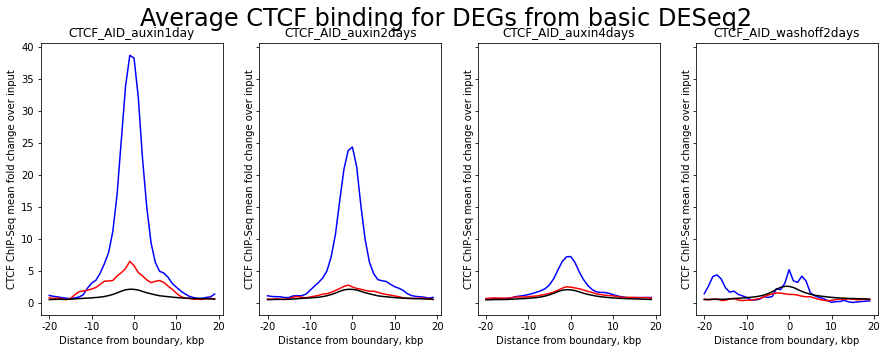

In [64]:
# Need Chip-Seq file for mm10
chip_seq_file = "/project/fudenber_735/collaborations/karissa_2022/RNAseq/features/mm10/E14_CTCF/RSC13_E14_CTCF_new.scale.bw"
DE_result_dict = basic_deseq_ctcf
pval_cutoff = 0.05

deseq_degs_ctcf_binding(basic_deseq_ctcf, 
                        "Average CTCF binding for DEGs from basic DESeq2",
                        pval_cutoff,
                        chip_seq_file)

==== General percentages for Condition : CTCF_AID_auxin1day====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 263
Number of DE transcripts with an annotated TSS: 261
Number of up-regulated genes: 115
Number of down-regulated genes: 146

==== General percentages for Condition : CTCF_AID_auxin2days====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 897
Number of DE transcripts with an annotated TSS: 879
Number of up-regulated genes: 592
Number of down-regulated genes: 287

==== General percentages for Condition : CTCF_AID_auxin4days====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 4042
Number of DE transcripts with an annotated TSS: 3991
Number of up-regulated genes: 2296
Number of down-regulated genes: 1695

==== General percentages for Condition : CTCF_AID_washoff2days====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 213
Number of DE transcripts with an annotated TSS: 197
Number of 

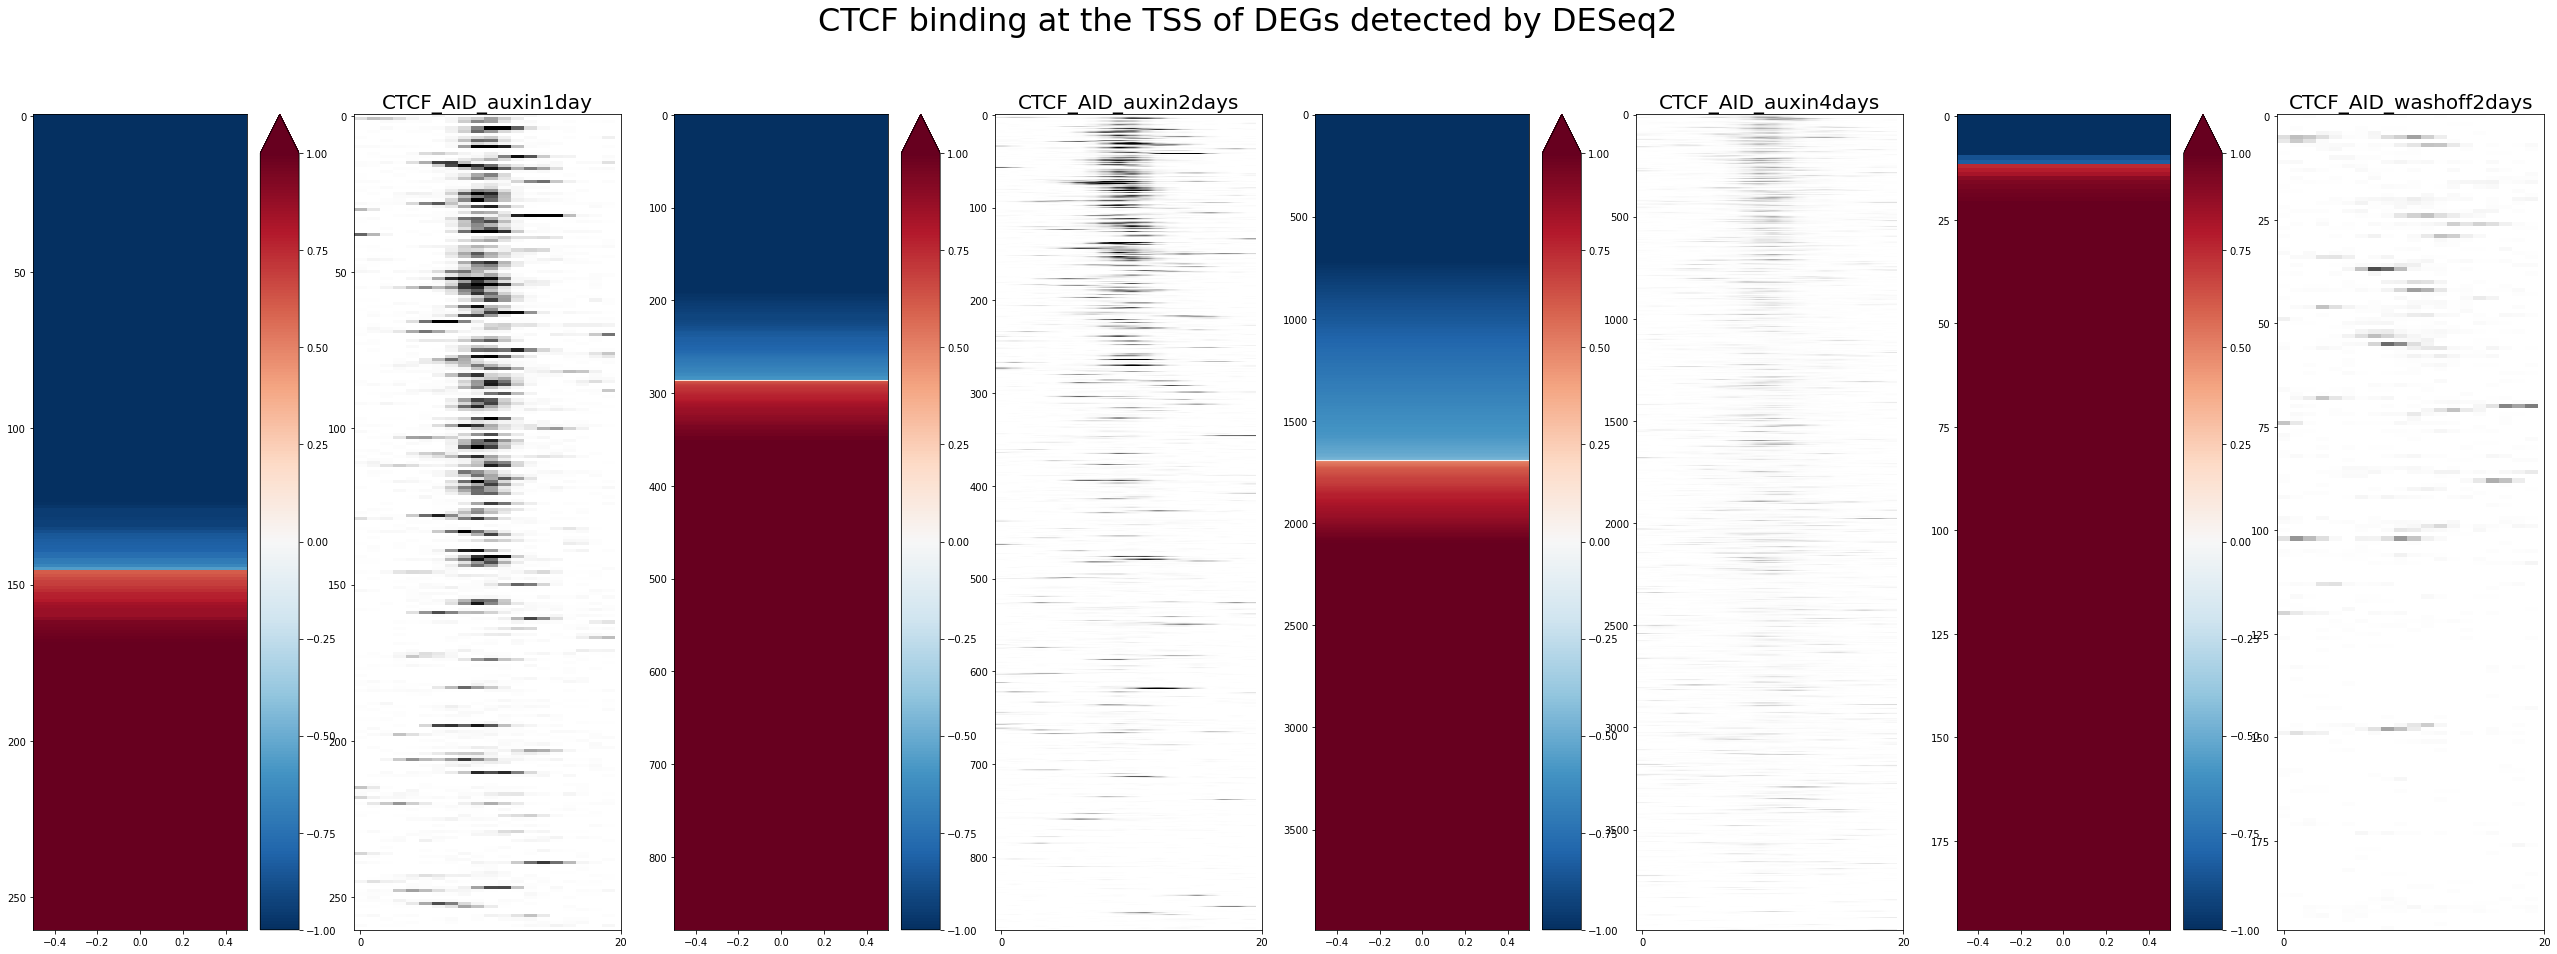

In [65]:
plot_deseq_CTCF_binding_together(basic_deseq_ctcf, 
                                 tss_df,
                                 chip_seq_file,
                                 pval_cutoff,
                                 "CTCF binding at the TSS of DEGs detected by DESeq2")

### Notes/Observations

Comparing to mm9 dataset: the numbers are comparable, although it looks like we're losing more of the transcripts after merging by gene_id. 

I think metaseq does this stack-up purely by intervals. I'll try it next to see how the results differ.

The stackup/heatmap graphs of CTCF binding look weird. I guess this might be the "lower counts" that Rini was talking about over slack. "I had resequenced RSC12 and RSC13 to get more reads. Got good number of reads for RSC12 (which is Rad21 ChIP). RSC13 (CTCF ChIP) is also good but still fewer reads than I was aiming for. And hence these samples which were sequenced again are called new_scale (edited).
I need to merge my previous and the new RSC13 fastq files so that overall there are more reads when combined together and remap. Nevertheless, the ChIP quality is decent. Will be doing the merge and remap it soon and share.
Have generated the bw files for the input. Will just view them on the browser once and share." 

In [57]:
## To average CTCF signal for up-regulated vs down-regulated genes
def deseq_degs_ctcf_binding(DE_result_dict, figure_title, pval_cutoff, chip_seq_file):

    # Getting plots ready
    fig, ax = plt.subplots(1,len(DE_result_dict), sharey=True, figsize=(15, 5))
    fig.suptitle(figure_title, fontsize=24)
    i = 0

    for condition, DE_result_df in DE_result_dict.items():

        # lookup the TSS for this set of transcripts
        DE_results_TSS = DE_result_df.merge(tss_df.drop_duplicates(['gene_id']), left_index=True, right_on='gene_id')

        # how many did not have a transcript/were dropped?
        ni = len(DE_result_df)
        ntss = len(DE_results_TSS)
        print("Out of " + str(ni) + " transcripts from the sleuth output results, " + str(ntss) + " had corresponding TSS from ensembl GTF files.")
        print("Lost " + str(ni-ntss) + " transcripts for this analysis.")

        # Extracting significantly DE transcripts
        sig_DE = DE_results_TSS[DE_results_TSS['padj'] < pval_cutoff]
        sig_DE_up = sig_DE[sig_DE['log2FoldChange'] > 0]
        sig_DE_down = sig_DE[sig_DE['log2FoldChange'] <= 0]

        # Will also look at enrichment around transcripts that were in RNAseq dataset that did not have significant DE
        nonsig_DE = DE_results_TSS[DE_results_TSS['pvalue'] >= pval_cutoff]

        nbins = 40

        # initializing variables for pybbi matrices
        DE_up_matrix = None
        DE_down_matrix = None

        # Generating summary of chip seq signal within the bins -1000 and +1000 from the TSS loc
        with bbi.open(chip_seq_file) as f:
            if not sig_DE_up.empty:
                DE_up_matrix = f.stackup(sig_DE_up['chrom'], sig_DE_up['start'] - 1000, sig_DE_up['end'] + 1000, bins=nbins)
            if not sig_DE_down.empty:
                DE_down_matrix = f.stackup(sig_DE_down['chrom'], sig_DE_down['start'] - 1000, sig_DE_down['end'] + 1000, bins=nbins)
            nonsig_DE_matrix = f.stackup(nonsig_DE['chrom'], nonsig_DE['start'] - 1000, nonsig_DE['end'] + 1000, bins=nbins)



        if DE_down_matrix is not None:
            ax[i].plot(np.nanmean(DE_down_matrix, axis=0), color = 'b' )

        if DE_up_matrix is not None:
            ax[i].plot(np.nanmean(DE_up_matrix, axis=0), color = 'r' )

        ax[i].plot(np.nanmean(nonsig_DE_matrix, axis=0), color = 'k')

        ax[i].set(xticks=np.arange(0, nbins+1, 10),
               xticklabels=(np.arange(0, nbins+1, 10)-nbins//2),
               xlabel='Distance from boundary, kbp',
               ylabel='CTCF ChIP-Seq mean fold change over input')
        ax[i].set_title(condition)

        i+=1


In [100]:
plt.savefig("avg_ctcf_binding_deseq")

<Figure size 432x288 with 0 Axes>

In [101]:
# import DEseq results

# Importing the .csv outputs from sleuth WT for each of the conditions into pandas dataframes:
deseq_batch_results = {}

folder = "/project/fudenber_735/GEO/nora_2017_rna-seq_SRP106652/deseq-mm9-results/"

for c in conditions[1:]:
    
    df = pd.read_csv(folder+"pairwise_batch_deseq_wt_"+c+".csv", index_col = 0)
    deseq_batch_results[c] = df

Out of 26520 transcripts from the sleuth output results, 25785 had corresponding TSS from ensembl GTF files.
Lost 735 transcripts for this analysis.
Out of 26520 transcripts from the sleuth output results, 25785 had corresponding TSS from ensembl GTF files.
Lost 735 transcripts for this analysis.
Out of 26520 transcripts from the sleuth output results, 25785 had corresponding TSS from ensembl GTF files.
Lost 735 transcripts for this analysis.
Out of 26520 transcripts from the sleuth output results, 25785 had corresponding TSS from ensembl GTF files.
Lost 735 transcripts for this analysis.


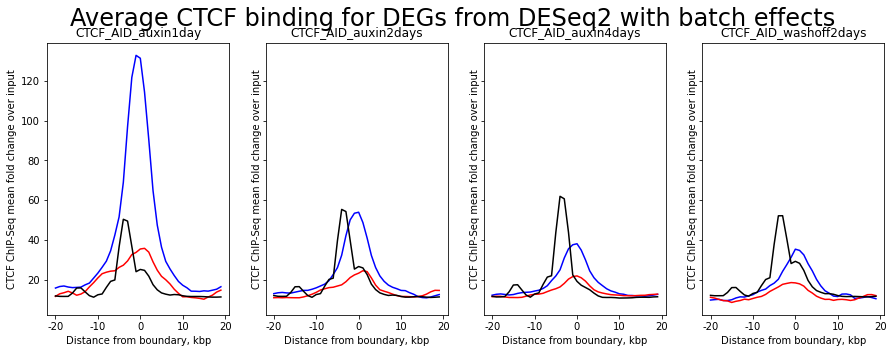

In [106]:
chip_seq_file = "/scratch/pokorny/Elphege_2017/GSM2609195_CTCF_ChIP-exo_WT-untagged_untreated_rep1_ENC1_tagDensity.bw"
cutoff = 0.05
ctcf_keys = [x for x in list(deseq_batch_results.keys()) if 'CTCF' in x]
deseq_batch_ctcf = {condition: deseq_batch_results[condition] for condition in ctcf_keys }


deseq_degs_ctcf_binding(deseq_batch_ctcf, 
                        "Average CTCF binding for DEGs from DESeq2 with batch effects", 
                        cutoff, 
                        chip_seq_file)

In [108]:
plt.savefig("avg_ctcf_binding_deseq_batch")

<Figure size 432x288 with 0 Axes>

==== General percentages for Condition : CTCF_AID_auxin1day====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 1264
Number of DE transcripts with an annotated TSS: 1249
Number of up-regulated genes: 518
Number of down-regulated genes: 731

==== General percentages for Condition : CTCF_AID_auxin2days====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 3759
Number of DE transcripts with an annotated TSS: 3699
Number of up-regulated genes: 1421
Number of down-regulated genes: 2278

==== General percentages for Condition : CTCF_AID_auxin4days====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 6700
Number of DE transcripts with an annotated TSS: 6598
Number of up-regulated genes: 3051
Number of down-regulated genes: 3547

==== General percentages for Condition : CTCF_AID_washoff2days====
Setting qval cutoff to: 0.05
Number of DE transcripts with this cutoff: 990
Number of DE transcripts with an annotated TSS: 971
Numb

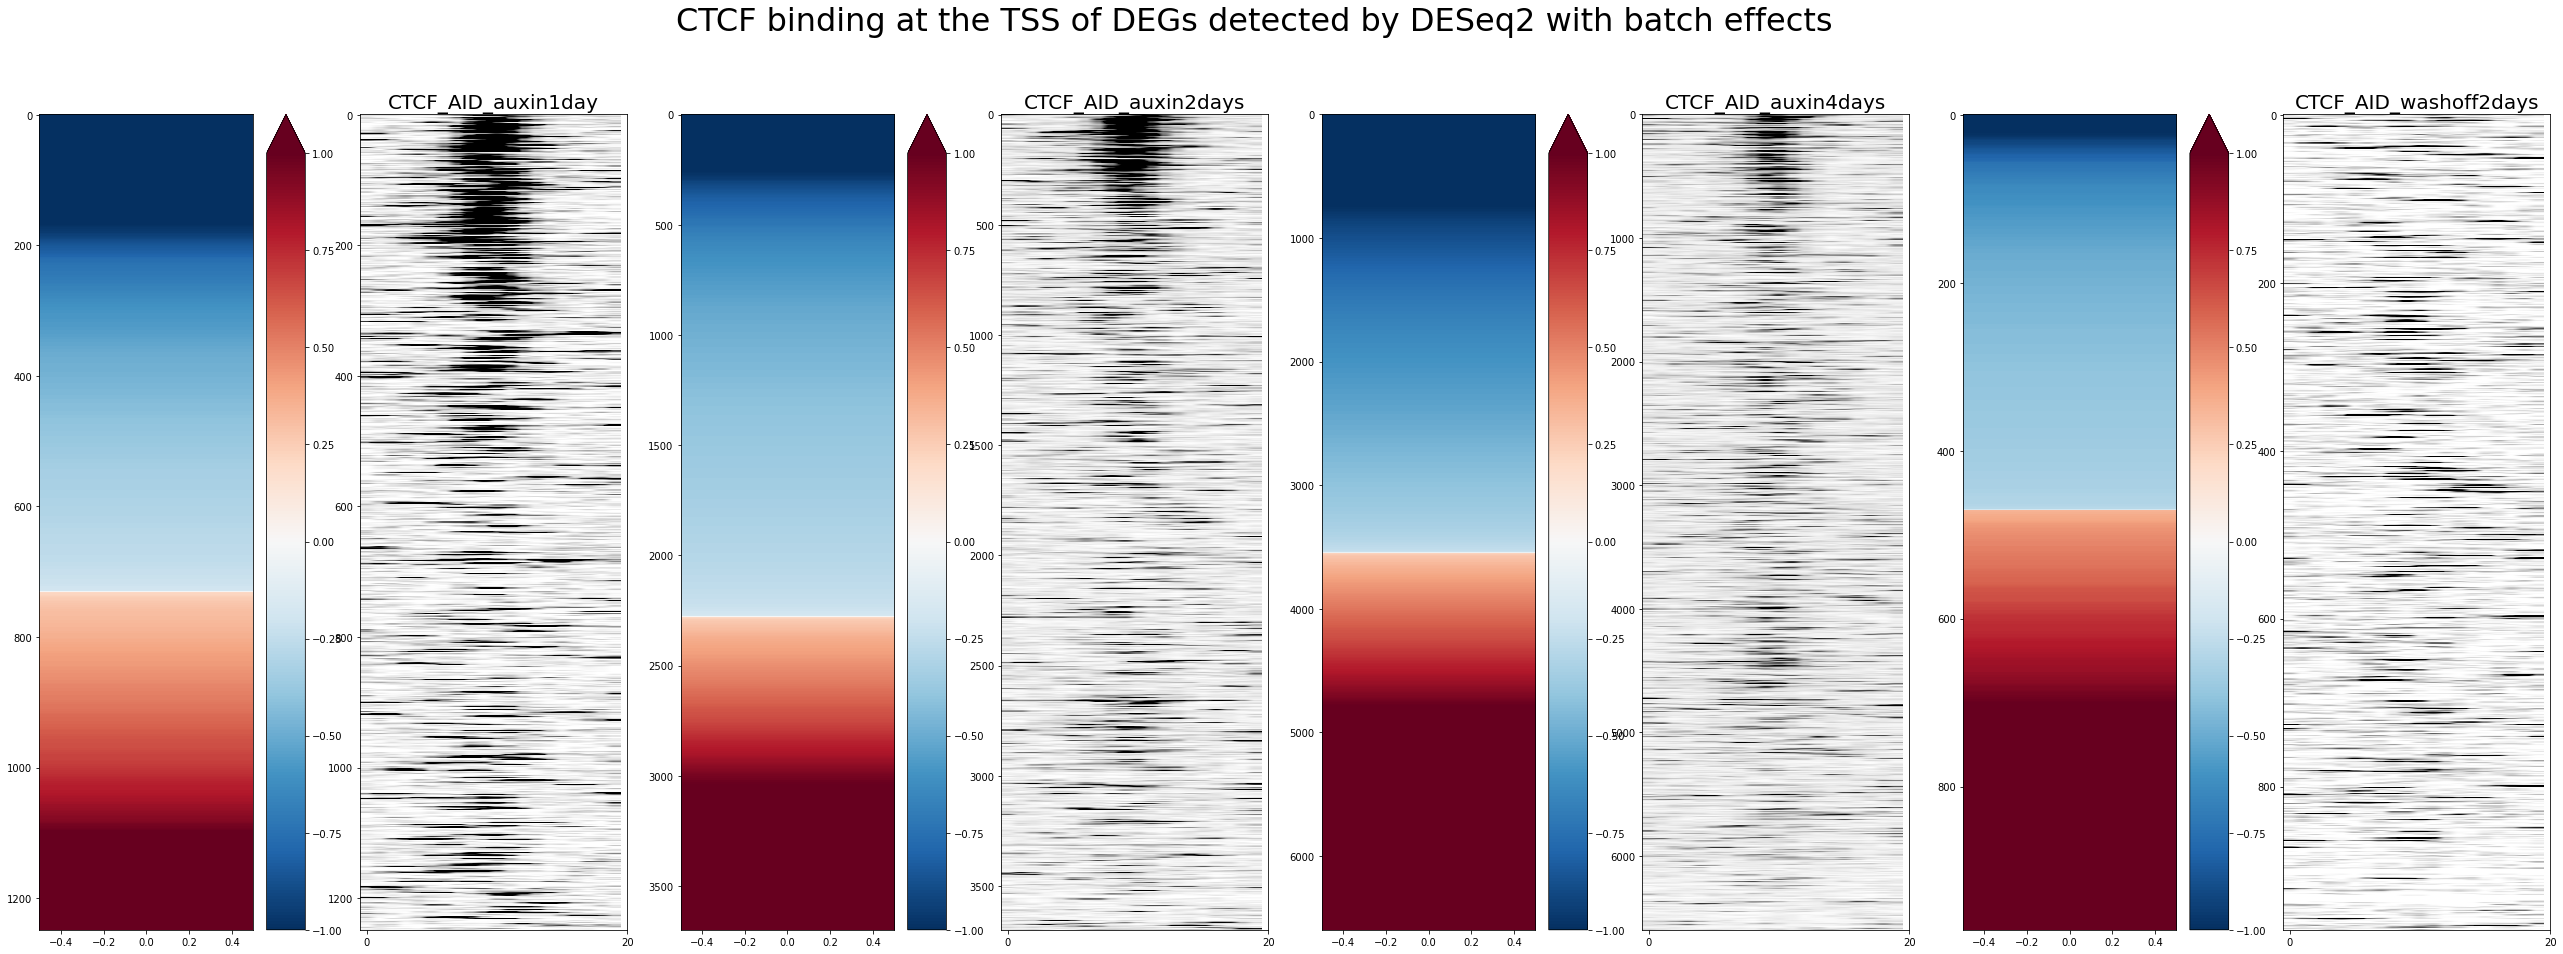

In [102]:
plot_deseq_CTCF_binding_together(deseq_batch_ctcf, 
                                 tss_df,
                                 chip_seq_file,
                                 cutoff,
                                 "CTCF binding at the TSS of DEGs detected by DESeq2 with batch effects")

In [103]:
plt.savefig("ctcf_binding_tss_deseq_batch")

<Figure size 432x288 with 0 Axes>

In [62]:
## For plotting the log change in FPKM, as a measure of differential expression, alongside the binding of 
## that transcript at it's TSS.
# 
# cutoff: the deltaFPKM to take
# DE_df: must have the columns 'delta' for the FPKM, must be in sorted order by delta
# CTCF ChIP-exo filepath
def plot_deseq_CTCF_binding_together(DE_result_dict, tss_df, chip_seq_file, qval_cutoff, plot_title):
    
    
    # Getting plots ready
    fig, ax = plt.subplots(1,2*len(DE_result_dict), figsize=(45, 15))
    fig.suptitle(plot_title, fontsize=32)
    i = 0
    
    for condition, DE_result_df in DE_result_dict.items():

        # Extracting only rows that are above the cutoff
        sig_DE = DE_result_df[DE_result_df['padj'] < qval_cutoff]

        sig_DE = sig_DE.sort_values(by=['log2FoldChange'])

        n_DE_tot = len(sig_DE)

        # lookup the TSS for this set of transcripts
        window_df = sig_DE.merge(tss_df.drop_duplicates(['gene_id']), left_index=True, right_on='gene_id')
        

        # Generating summary of chip seq signal within the bins -1000 and +1000 from the TSS loc
        with bbi.open(chip_seq_file) as f:
            DE_matrix = f.stackup(window_df['chrom'], window_df['start'] - 1000, window_df['end'] + 1000, bins=20)


        # split by positive and negative values for plotting
        DE_up = window_df[window_df['log2FoldChange'] > 0]
        DE_down = window_df[window_df['log2FoldChange'] < 0]

        n = len(window_df)
        n_up = len(DE_up)
        n_down = len(DE_down)

        print("==== General percentages for Condition : " + condition + "====")
        print("Setting qval cutoff to: " + str(qval_cutoff))
        print("Number of DE transcripts with this cutoff: " + str(n_DE_tot))
        print("Number of DE transcripts with an annotated TSS: " + str(n))
        print("Number of up-regulated genes: " + str(n_up))
        print("Number of down-regulated genes: " + str(n_down))
        print()


        # extracting the beta change vector
        logFPKM = window_df['log2FoldChange']
        logFPKM = np.transpose(np.expand_dims(logFPKM, axis=0))
        minval=np.min(logFPKM)
        maxval=np.max(logFPKM)
        # if diverging, color negative values blue
        if (minval < 0):
            divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
            hotcoldmap = plt.cm.get_cmap('RdBu').reversed()
            occ = ax[i].imshow(logFPKM, cmap=hotcoldmap, norm=divnorm, aspect='auto')
        # pcolormesh(your_data, cmap="coolwarm", norm=divnorm)
        else:
            minval= 0
            occ = ax[i].imshow(logFPKM, cmap='Reds', norm=colors.Normalize(vmin=0, vmax=1), aspect='auto')


        cbar = ax[i].figure.colorbar(occ, ax=ax[i], extend='max')
        i+=1
        name = condition
        ax[i].set_title(name, fontsize=20)
        # Plotting ctcf binding
        fig = ax[i].imshow(DE_matrix, cmap='gray_r', aspect='auto', vmin=0, vmax=100)
        ax[i].set_xticks([0, 20])
        i+=1

    plt.show()

In [110]:
up_deseq = {}
down_deseq = {}
up_batch_deseq = {}
down_batch_deseq = {}
qval_cutoff = 0.05

for cond, DE_results in deseq_results.items():

    sig_DE = DE_results[DE_results['padj'] < qval_cutoff]
    sig_DE_up = sig_DE[sig_DE['log2FoldChange'] > 0]
    sig_DE_down = sig_DE[sig_DE['log2FoldChange'] <= 0]
    
    up_deseq[cond] = len(sig_DE_up)
    down_deseq[cond] = len(sig_DE_down)
    
for cond, DE_results in deseq_batch_results.items():
    
    sig_DE = DE_results[DE_results['padj'] < qval_cutoff]
    sig_DE_up = sig_DE[sig_DE['log2FoldChange'] > 0]
    sig_DE_down = sig_DE[sig_DE['log2FoldChange'] <= 0]
    
    up_batch_deseq[cond] = len(sig_DE_up)
    down_batch_deseq[cond] = len(sig_DE_down)
    
    


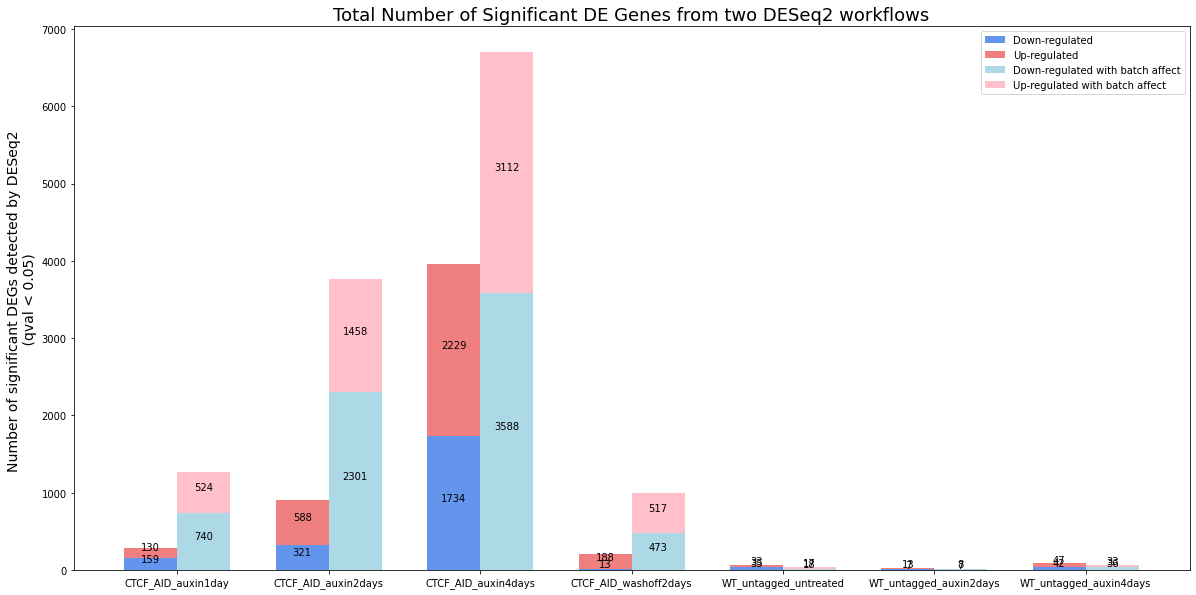

In [114]:
width = 0.35

fig, ax = plt.subplots(figsize=[20,10])

downbars = ax.bar(down_deseq.keys(), list(down_deseq.values()), -width, align='edge', label = "Down-regulated", color='cornflowerblue')
upbars = ax.bar(up_deseq.keys(), list(up_deseq.values()), -width, align='edge', bottom = list(down_deseq.values()), label = "Up-regulated", color='lightcoral')

downbars2 = ax.bar(down_batch_deseq.keys(), list(down_batch_deseq.values()), +width, align='edge', label = "Down-regulated with batch affect", color='lightblue')
upbars2 = ax.bar(up_batch_deseq.keys(), list(up_batch_deseq.values()), +width, align='edge', bottom = list(down_batch_deseq.values()), label = "Up-regulated with batch affect", color='pink')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        b = rect.get_y()
        plt.text(rect.get_x() + rect.get_width()/2., .5*(height)+b,
                '%d' % int(height),
                ha='center', va='bottom')


plt.ylabel("Number of significant DEGs detected by DESeq2 \n (qval < 0.05) ", size=14)
plt.title("Total Number of Significant DE Genes from two DESeq2 workflows", size=18)
plt.legend()

autolabel(upbars)
autolabel(upbars2)
autolabel(downbars)
autolabel(downbars2)

plt.show()